# Genesis4 Particles

This shows examples of the various ways to input particle data into Genesis4.

In [1]:
import logging

from genesis.version4 import Genesis4
from genesis.version4.input import (
    Genesis4Input,
    Line,
    Beam,
    Drift,
    Lattice,
    MainInput,
    ProfileArray,
    ProfileGauss,
    Setup,
    Time,
    Track,
    Write,
)
import os
import numpy as np
from scipy.constants import c
from math import sqrt, pi
import matplotlib.pyplot as plt

logging.basicConfig()
# logging.getLogger("genesis").setLevel("DEBUG")

%config InlineBackend.figure_format = 'retina'

# Lattice

Create a simple drift lattice

In [2]:
D1 = Drift(L=1)
lattice = Lattice(elements={"D1": D1, "LAT": Line(elements=[D1])})

# `profile_gauss`

This profile will make a Gaussian distribition. Here we do some calculations to make the correct bunch length for a given bunch charge to provide a peak current.

In [3]:
PEAK_CURRENT = 1000
BUNCH_CHARGE = 100e-12
SIGMA_T = BUNCH_CHARGE / (sqrt(2 * pi) * PEAK_CURRENT)
SIGMA_Z = SIGMA_T * c
SLEN = 6 * SIGMA_Z
S0 = 3 * SIGMA_Z
SIGMA_T, SIGMA_Z, SLEN

(3.989422804014327e-14, 1.1959988684167075e-05, 7.175993210500245e-05)

In [4]:
main = MainInput(
    namelists=[
        Setup(
            rootname="drift_test",
            # lattice="LATFILE",
            beamline="LAT",
            gamma0=1000,
            lambda0=1e-07,
            delz=0.026,
            seed=123456,
            npart=128,
        ),
        Time(slen=SLEN),
        ProfileGauss(
            label="beamcurrent",
            c0=PEAK_CURRENT,
            s0=S0,
            sig=SIGMA_Z,
        ),
        Beam(
            gamma=1000,
            delgam=1,
            current="beamcurrent",
        ),
        Track(zstop=1),
        Write(beam="end"),
    ],
)

G = Genesis4(main, lattice, verbose=True)
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpz7_jvppg
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpz7_jvppg
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:35:46 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 71.8 microns with 718 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 718 slices for a time window of 71.8 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...



Program is terminating...
Ending Time: Tue May 14 16:35:46 2024
Total Wall Clock Time: 0.15892 seconds
-------------------------------------
Success - execution took 0.27s.


In [5]:
G.input.main.setup.delz

0.026

In [6]:
print(G.output.run.output_log)

---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:35:46 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 71.8 microns with 718 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 718 slices for a time window of 71.8 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...

Program is terminating...
Ending Time: Tue May 14 16:35:46 2024
Total Wall Clock Time: 0.15892 seconds
-------------------------------------



<ParticleGroup with 91904 particles at 0x1077887a0>

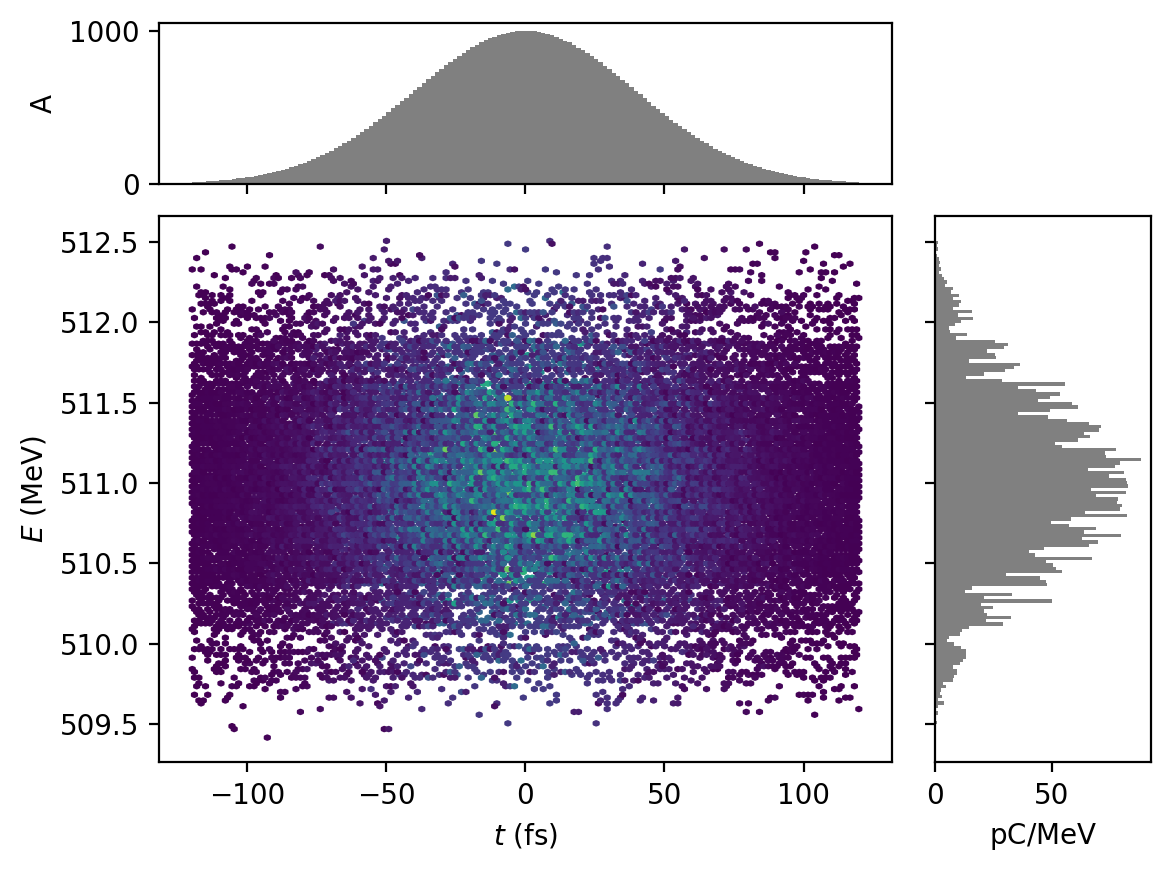

In [7]:
output.load_particles()
P1 = output.particles["end"]
P1.drift_to_z()
P1.plot("t", "energy")
P1

In [8]:
output.particles["end"]

<ParticleGroup with 91904 particles at 0x1077887a0>

Check the charge

In [9]:
P1.charge

9.973150081144012e-11

# `profile_file`

LUME-Genesis automatically makes an HDF5 file with `ProfileArray`.

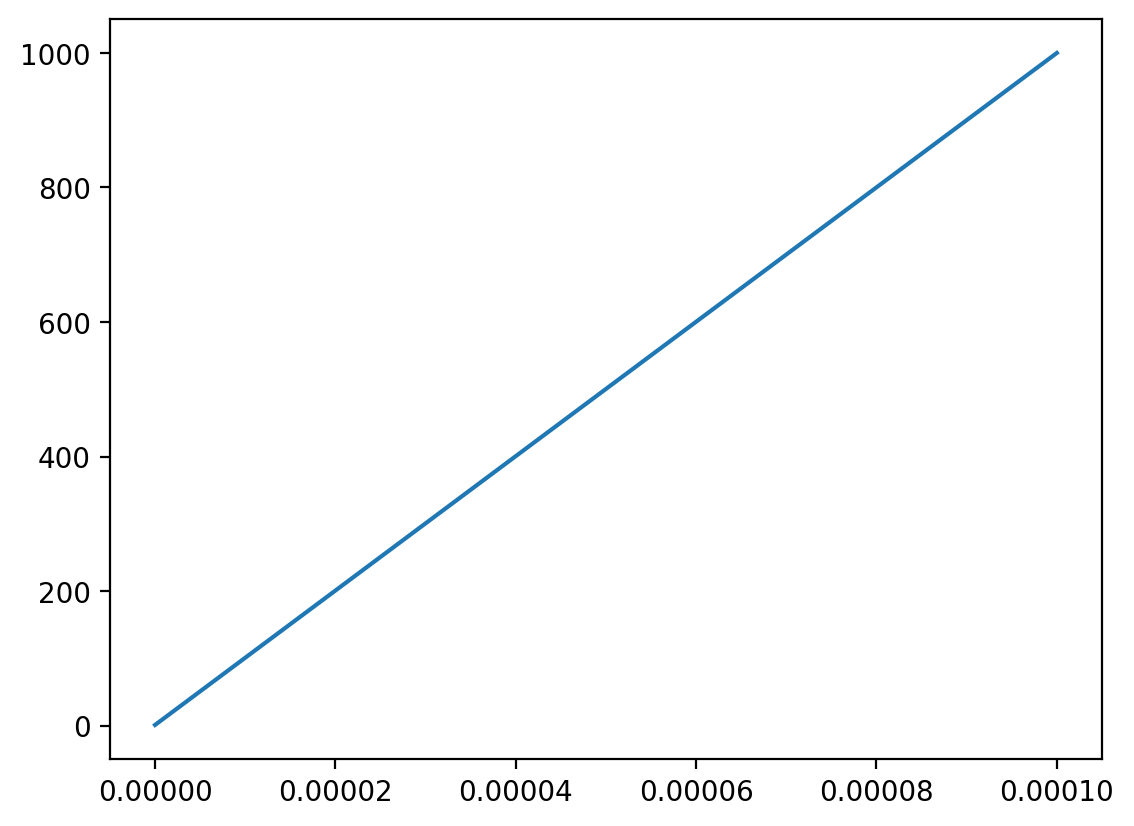

In [10]:
NPTS = 100
SLEN = 100e-6
S = np.linspace(0, SLEN, NPTS)
CURRENT = np.linspace(1, 1000.0, NPTS)
plt.plot(S, CURRENT)

In [11]:
main = MainInput(
    namelists=[
        Setup(
            rootname="drift_test",
            # lattice=lattice,
            beamline="LAT",
            gamma0=1000,
            lambda0=1e-07,
            delz=0.026,
            seed=123456,
            npart=128,
        ),
        Time(slen=SLEN),
        ProfileArray(label="beamcurrent", xdata=S, ydata=CURRENT),
        Beam(
            gamma=1000,
            delgam=1,
            current="beamcurrent",
            ex=1e-06,
            ey=1e-06,
            betax=7.910909406464387,
            betay=16.881178621346898,
            alphax=-0.7393217413918415,
            alphay=1.3870723536888105,
        ),
        Track(zstop=1),
        Write(beam="end"),
    ]
)

input = Genesis4Input(
    main=main,
    lattice=lattice,
)
G = Genesis4(input=input, verbose=True)
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpckdjmmev
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpckdjmmev
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:35:47 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 1000 slices for a time window of 100 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...



Program is terminating...
Ending Time: Tue May 14 16:35:47 2024
Total Wall Clock Time: 0.214834 seconds
-------------------------------------
Success - execution took 0.33s.


### Inspect the input and output

In [12]:
print(main.to_genesis())

&setup
  rootname = drift_test
  lattice = genesis.lat
  beamline = LAT
  gamma0 = 1000.0
  lambda0 = 1e-07
  delz = 0.026
  seed = 123456
  npart = 128
&end

&time
  slen = 0.0001
&end

&profile_file
  label = beamcurrent
  xdata = ProfileArray_0.h5/x
  ydata = ProfileArray_0.h5/y
&end

&beam
  gamma = 1000.0
  delgam = 1.0
  current = @beamcurrent
  ex = 1e-06
  ey = 1e-06
  betax = 7.910909406464387
  betay = 16.881178621346898
  alphax = -0.7393217413918415
  alphay = 1.3870723536888105
&end

&track
  zstop = 1.0
&end

&write
  beam = end
&end


In [13]:
print(lattice.to_genesis())

D1: drift = {l=1.0};
LAT: LINE = {D1};


In [14]:
print(output.run.output_log)

---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:35:47 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 1000 slices for a time window of 100 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...

Program is terminating...
Ending Time: Tue May 14 16:35:47 2024
Total Wall Clock Time: 0.214834 seconds
-------------------------------------



In [15]:
output.meta

{'Beamdumps': {'ndumps': 0},
 'Fielddumps': {'ndumps': 0},
 'HOST': 'Undefined',
 'InputFile': '&setup\n  rootname = drift_test\n  lattice = genesis.lat\n  beamline = LAT\n  gamma0 = 1000.0\n  lambda0 = 1e-07\n  delz = 0.026\n  seed = 123456\n  npart = 128\n&end\n\n&time\n  slen = 0.0001\n&end\n\n&profile_file\n  label = beamcurrent\n  xdata = ProfileArray_0.h5/x\n  ydata = ProfileArray_0.h5/y\n&end\n\n&beam\n  gamma = 1000.0\n  delgam = 1.0\n  current = @beamcurrent\n  ex = 1e-06\n  ey = 1e-06\n  betax = 7.910909406464387\n  betay = 16.881178621346898\n  alphax = -0.7393217413918415\n  alphay = 1.3870723536888105\n&end\n\n&track\n  zstop = 1.0\n&end\n\n&write\n  beam = end\n&end\n',
 'LatticeFile': 'D1: drift = {l=1.0};\nLAT: LINE = {D1};\n',
 'TimeStamp': 'Tue May 14 16:35:47 2024\n',
 'User': 'klauer',
 'Version': {'Beta': 0.0,
  'Build_Info': 'Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: ',
  'Major': 4.0,
  'Minor': 6.0,
  'Revision': 4.0},
 'cwd': '/private

<ParticleGroup with 128000 particles at 0x146881d30>

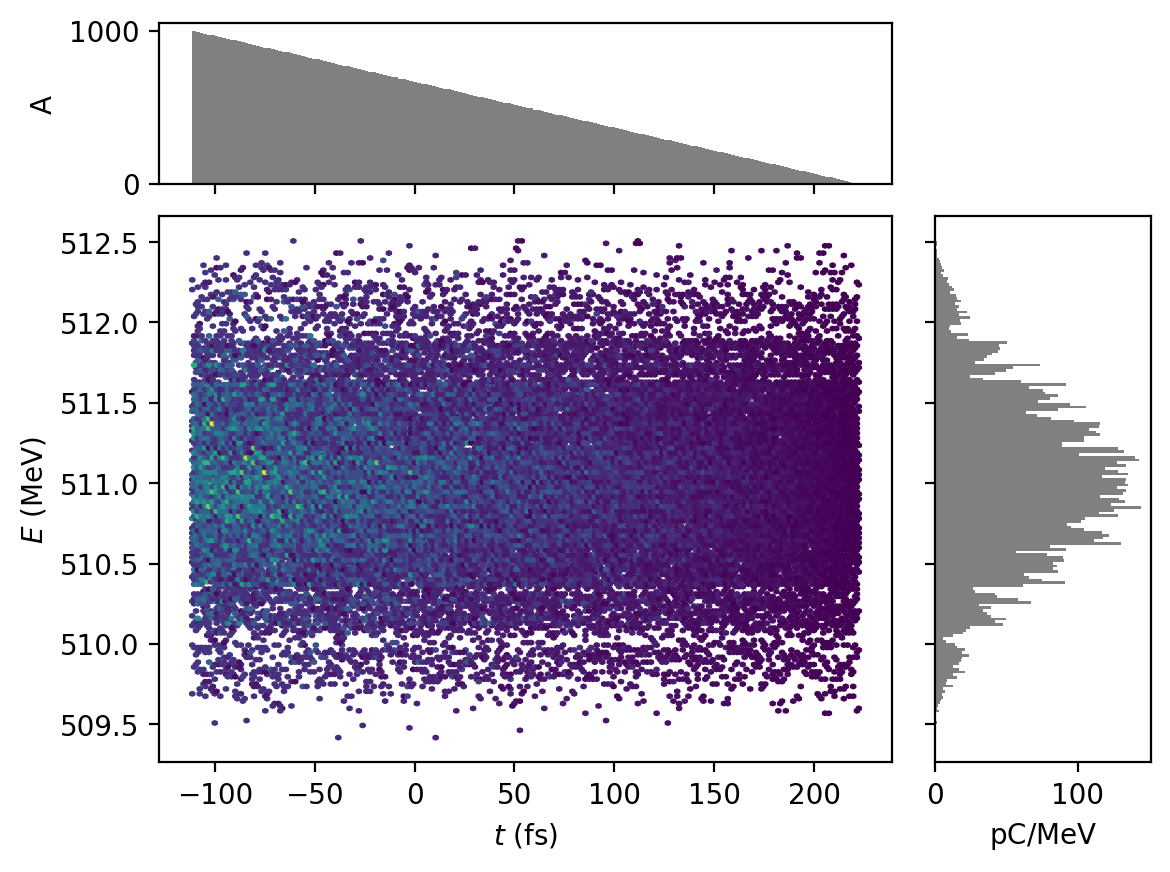

In [16]:
output.load_particles()
P1 = output.particles["end"]
P1.drift_to_z()
P1.plot("t", "energy")
P1

Resample particles for equal weights. This is neccessary when reading from a distribution file.

<ParticleGroup with 128000 particles at 0x148153f50>

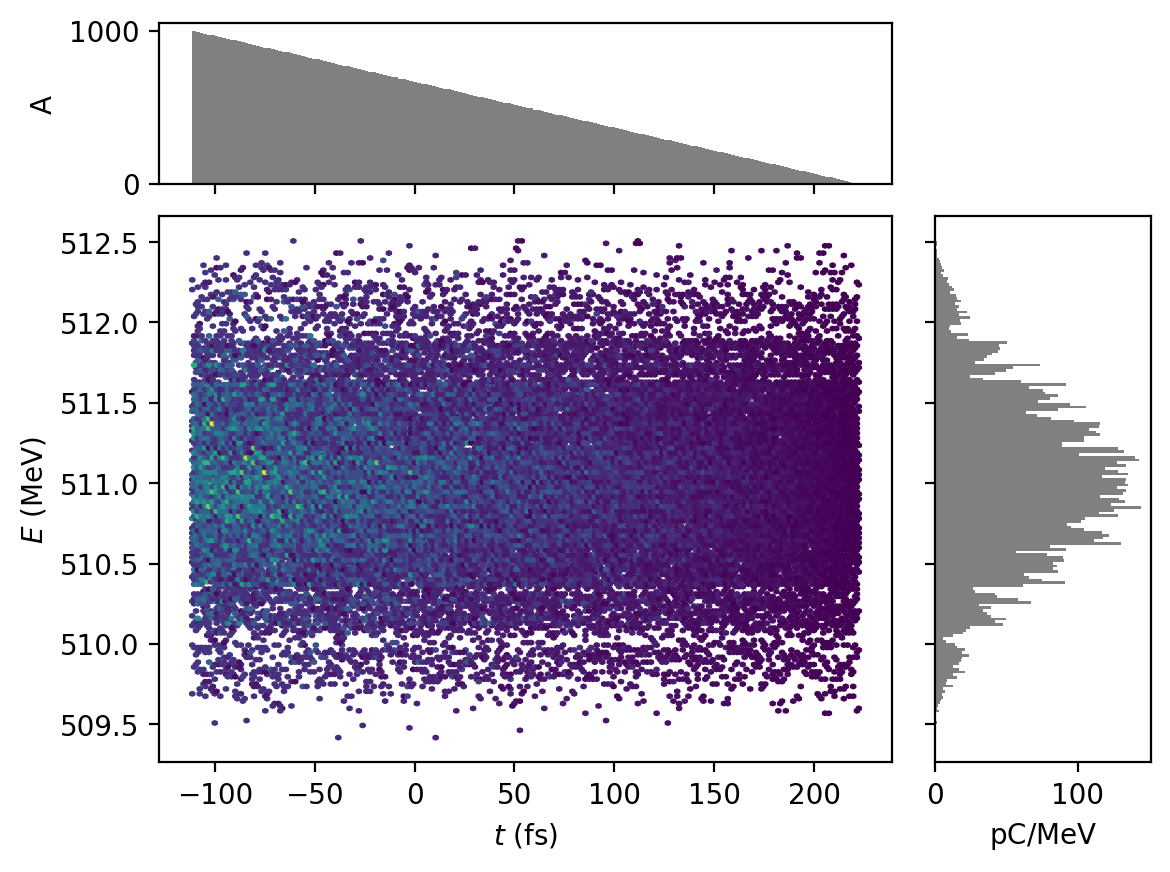

In [17]:
NSAMPLE = len(P1)
P1r = P1.resample(NSAMPLE)
P1r.plot("t", "energy")
P1r

Make a more interesting distribution from this:

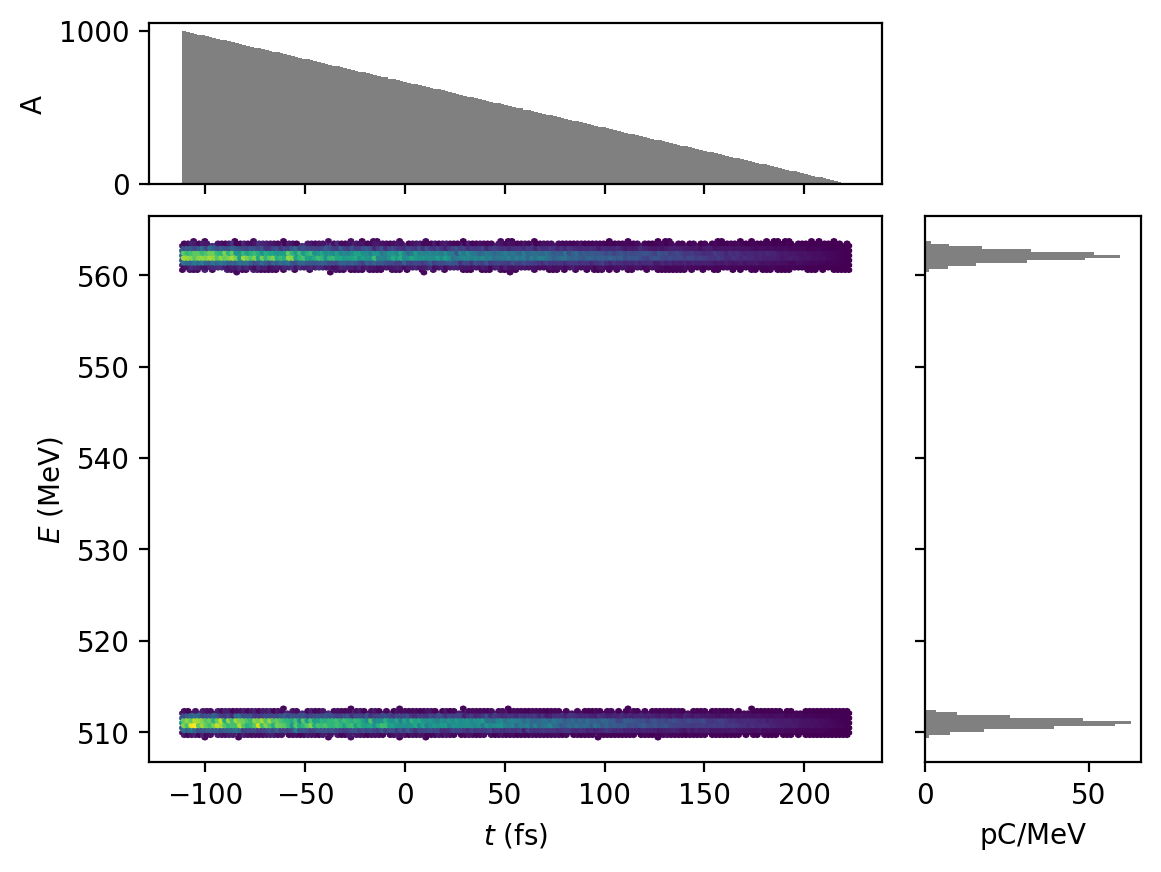

In [18]:
P1r.pz[0 : len(P1) // 2] *= 1.1
P1r.plot("t", "energy")

ParticleGroup can write to a file for Genesis4.

In [19]:
DIST_FILE = "genesis4_distribution.h5"
P1r.write_genesis4_distribution(DIST_FILE, verbose=True)

Resampling 128000 weighted particles


Datasets x, xp, y, yp, t, p written to: genesis4_distribution.h5


# InitialParticles

Use this file as the input to a new simulation. 

When using the lume-genesis-specific `InitialParticles` namelist, the appropriate input will be written automatically. 
Be sure to add it before the first "Track" or "Write" namelist in the main input.

In [20]:
from genesis.version4.input import InitialParticles

initial_particles = InitialParticles(particles=P1r)

main = MainInput(
    namelists=[
        Setup(
            rootname="drift_test",
            # lattice=full_path(LATFILE),
            beamline="LAT",
            gamma0=1000,
            lambda0=1e-07,
            delz=0.026,
            seed=123456,
            npart=512,
        ),
        Time(slen=initial_particles.slen),
        initial_particles,
        Track(zstop=1),
        Write(beam="end"),
    ],
)

input = Genesis4Input(
    main=main,
    lattice=lattice,
)
G1 = Genesis4(input=input, verbose=True)
output = G1.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp39t2c0op
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp39t2c0op
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
Resampling 128000 weighted particles


Datasets x, xp, y, yp, t, p written to: /private/var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp39t2c0op/InitialParticles_0.h5
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:36:06 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Importing distribution file... 
Charge of external distribution: 1.66782e-10
Particles in external distribution: 128000
Analysing external distribution... 
Analysis of the imported distribution
   Total Bunch Length  (microns): 99.6847
   Length for Matching (microns): 99.6847
   Energy                  (MeV): 536.552
   Norm. Emittance in x (micron): 1.00046
   Norm. Emittance in y (micron): 1.00337
   Beta Function in x        (m): 10.0366
   Beta Function in y        (m): 14.9003
   Alpha Function in x          : -0.935504
   Alpha Functio


Running Core Simulation...
Time-dependent run with 1000 slices for a time window of 100 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...



Program is terminating...
Ending Time: Tue May 14 16:36:07 2024
Total Wall Clock Time: 0.408897 seconds
-------------------------------------
Success - execution took 8.71s.


In [21]:
import pprint

pprint.pprint(output.run)

RunInfo(error=False, error_reason='', run_script='/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in', run_time=8.706576249795035)


In [22]:
print(output.run.output_log)

---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Tue May 14 16:36:06 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Importing distribution file... 
Charge of external distribution: 1.66782e-10
Particles in external distribution: 128000
Analysing external distribution... 
Analysis of the imported distribution
   Total Bunch Length  (microns): 99.6847
   Length for Matching (microns): 99.6847
   Energy                  (MeV): 536.552
   Norm. Emittance in x (micron): 1.00046
   Norm. Emittance in y (micron): 1.00337
   Beta Function in x        (m): 10.0366
   Beta Function in y        (m): 14.9003
   Alpha Function in x          : -0.935504
   Alpha Function in y          : 1.21105
   Beam center in x     (micron): -0.278752
   Beam center in y     (micron): 0.351325
   Beam center in 

In [23]:
output.load_particles()
P2 = output.particles["end"]
P2.z

array([9.80929827e-09, 3.77890840e-08, 6.94268520e-08, ...,
       9.99477179e-05, 9.99725543e-05, 9.99978651e-05])

<ParticleGroup with 512000 particles at 0x1490ceb10>

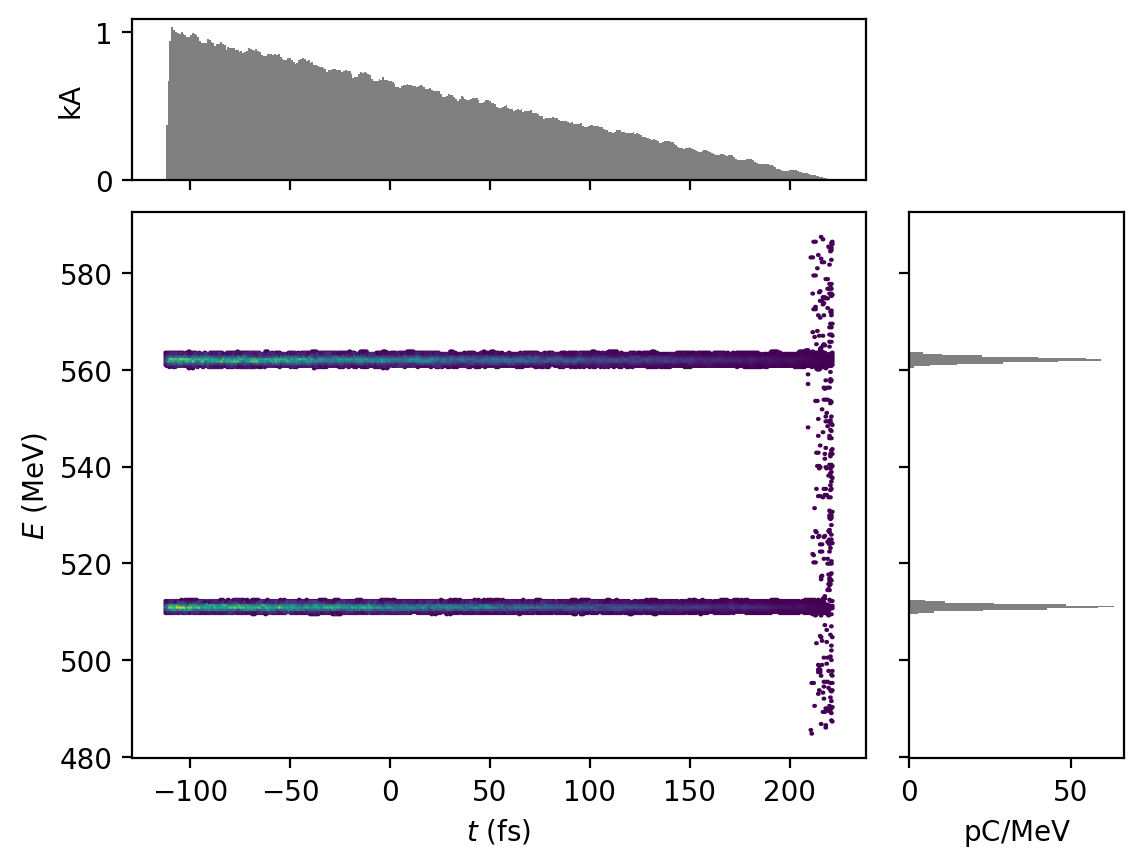

In [24]:
P2.drift_to_z()
P2.plot("t", "energy")
P2

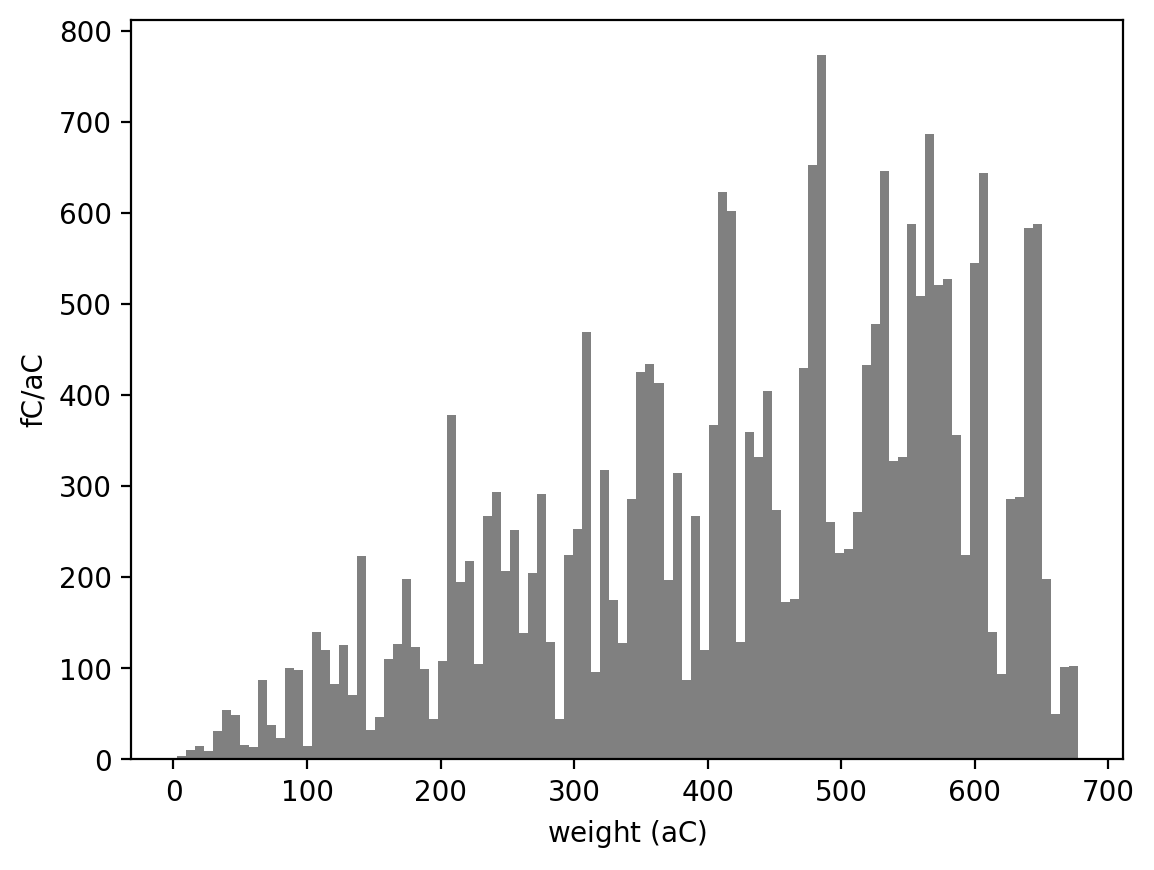

In [25]:
P2.plot("weight", bins=100)

Notice that `importdistribution` is filled in:

In [26]:
list(output.beam)

['LSCfield',
 'alphax',
 'alphay',
 'betax',
 'betay',
 'bunching',
 'bunchingphase',
 'current',
 'efield',
 'emax',
 'emin',
 'emitx',
 'emity',
 'energy',
 'energyspread',
 'pxmax',
 'pxmin',
 'pxposition',
 'pymax',
 'pymin',
 'pyposition',
 'wakefield',
 'xmax',
 'xmin',
 'xposition',
 'xsize',
 'ymax',
 'ymin',
 'yposition',
 'ysize']

In [27]:
G1.input

Genesis4Input(main=MainInput(namelists=[Setup(type='setup', rootname='drift_test', outputdir='', lattice='genesis.lat', beamline='LAT', gamma0=1000.0, lambda0=1e-07, delz=0.026, seed=123456, npart=512, nbins=4, one4one=False, shotnoise=True, beam_global_stat=False, field_global_stat=False, exclude_spatial_output=False, exclude_fft_output=False, exclude_intensity_output=False, exclude_energy_output=False, exclude_aux_output=False, exclude_current_output=True, exclude_field_dump=False, write_meta_file=False, semaphore_file_name='', write_semaphore_file=False, write_semaphore_file_done=False, write_semaphore_file_started=False), Time(type='time', s0=0.0, slen=9.999850899316347e-05, sample=1, time=True), InitialParticles(type='InitialParticles', data={'x': array([ 8.67493475e-05, -1.11514462e-05, -1.09201793e-04, ...,
       -1.36693670e-04, -1.33433923e-04,  3.23872786e-05]), 'px': array([ -1342.32181262,   -268.51964389, -15516.16760833, ...,
       -15746.53578309,   -980.2627504 ,   76

# Cleanup

In [28]:
os.remove(DIST_FILE)